In [2]:
import torch
import torchvision

I0102 113021.815 _utils_internal.py:231] NCCL_DEBUG env var is set to None


I0102 113021.816 _utils_internal.py:249] NCCL_DEBUG is forced to WARN from None


# Download data

In [7]:
ROOT_FOLDER = "/home/yanchengyuan/local"

transform = torchvision.transforms.ToTensor()

train_set = torchvision.datasets.MNIST(ROOT_FOLDER, download=True, train=True, transform=transform)
valid_set = torchvision.datasets.MNIST(ROOT_FOLDER, download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)


Extracting /home/yanchengyuan/local/MNIST/raw/train-images-idx3-ubyte.gz to /home/yanchengyuan/local/MNIST/raw



Extracting /home/yanchengyuan/local/MNIST/raw/train-labels-idx1-ubyte.gz to /home/yanchengyuan/local/MNIST/raw



Extracting /home/yanchengyuan/local/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/yanchengyuan/local/MNIST/raw

Extracting /home/yanchengyuan/local/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/yanchengyuan/local/MNIST/raw



In [17]:
import matplotlib.pyplot as plt

def plot_sample(sample):
    plt.figure()
    plt.imshow(sample[0].squeeze())
    plt.title(f"digit: {sample[1]}")

I0102 113701.422 font_manager.py:1349] generated new fontManager


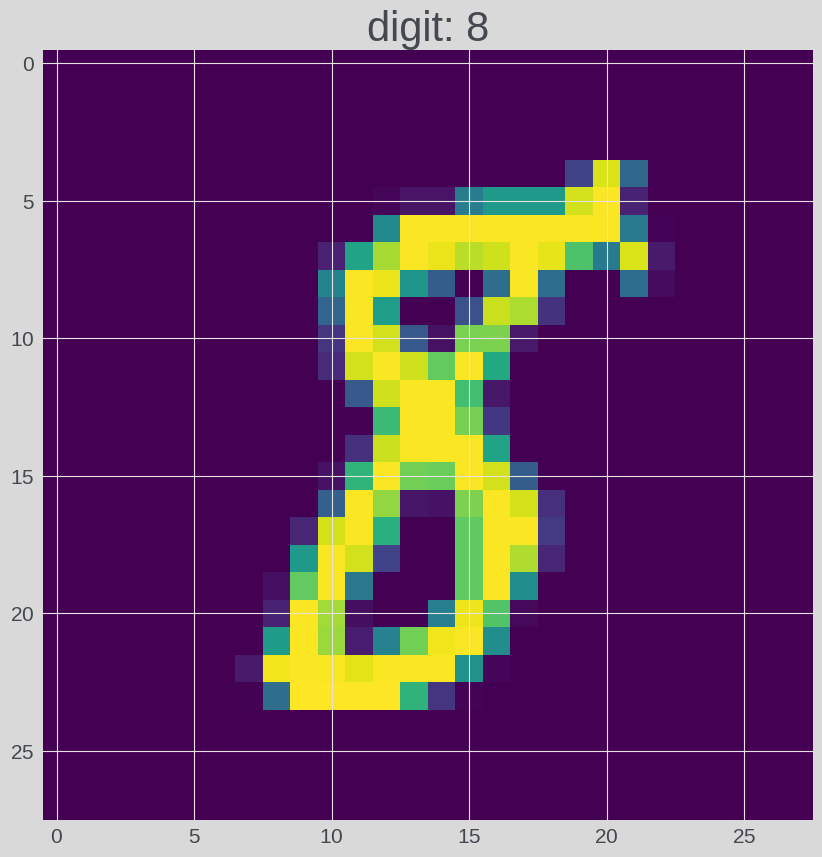

In [94]:
fuck = train_set[125]
plot_sample(fuck)

In [34]:
tmp = torch.cat([ f[0] for f in train_loader ], dim=0)
print(tmp.shape)
print(torch.mean(tmp))
print(torch.std(tmp))

torch.Size([60000, 1, 28, 28])
tensor(0.1307)
tensor(0.3081)


# Train an MNIST classifier

In [39]:
class MnistClassifier(torch.nn.Module):
    INPUT_DIM = 28 * 28
    def __init__(self, hidden_size=128):
        super(MnistClassifier, self).__init__()
        self._batch_norm_layer = torch.nn.BatchNorm1d(MnistClassifier.INPUT_DIM)
        self._hidden_layer = torch.nn.Linear(MnistClassifier.INPUT_DIM, hidden_size)
        self._output_layer = torch.nn.Linear(hidden_size, 10)  # 0...9

    def forward(self, x):
        """
        :param x: (batch_size, 28, 28) input image
        :return (batch_size, 10) probability of 0...9
        """
        x = x.view(-1, MnistClassifier.INPUT_DIM)
        #x = (x - 0.1307) / 0.3081 # mean, std computed from train set
        x = self._batch_norm_layer(x)
        x = self._hidden_layer(x)
        x = torch.nn.functional.relu(x)
        x = self._output_layer(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x


In [40]:
HIDDEN_SIZE = 128
MAX_EPOCH = 10
model = MnistClassifier(hidden_size=HIDDEN_SIZE)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [41]:
def train(model, criterion, optimizer, train_loader, valid_loader, max_epoch):
    for epoch in range(max_epoch):
        model.train()
        train_loss = 0
        for (images, labels) in train_loader:
            optimizer.zero_grad()

            pred = model(images)
            loss = criterion(pred, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} training loss {train_loss / len(train_loader):.3g}")

        model.eval()
        valid_loss = 0
        for (images, labels) in valid_loader:
            pred = model(images)
            loss = criterion(pred, labels)
            valid_loss += loss.item()
        print(f"Epoch {epoch} validation loss {valid_loss / len(valid_loader):.3g}")

In [42]:
train(model, criterion, optimizer, train_loader, valid_loader, 20)

Epoch 0 training loss 1.96


Epoch 0 validation loss 1.59


Epoch 1 training loss 1.3


Epoch 1 validation loss 1.04


Epoch 2 training loss 0.884


Epoch 2 validation loss 0.743


Epoch 3 training loss 0.672


Epoch 3 validation loss 0.595


Epoch 4 training loss 0.56


Epoch 4 validation loss 0.513


Epoch 5 training loss 0.49


Epoch 5 validation loss 0.455


Epoch 6 training loss 0.445


Epoch 6 validation loss 0.419


Epoch 7 training loss 0.414


Epoch 7 validation loss 0.391


Epoch 8 training loss 0.389


Epoch 8 validation loss 0.367


Epoch 9 training loss 0.368


Epoch 9 validation loss 0.354


Epoch 10 training loss 0.352


Epoch 10 validation loss 0.338


Epoch 11 training loss 0.338


Epoch 11 validation loss 0.334


Epoch 12 training loss 0.329


Epoch 12 validation loss 0.315


Epoch 13 training loss 0.319


Epoch 13 validation loss 0.308


Epoch 14 training loss 0.309


Epoch 14 validation loss 0.303


Epoch 15 training loss 0.3


Epoch 15 validation loss 0.293


Epoch 16 training loss 0.293


Epoch 16 validation loss 0.282


Epoch 17 training loss 0.287


Epoch 17 validation loss 0.276


Epoch 18 training loss 0.282


Epoch 18 validation loss 0.275


Epoch 19 training loss 0.276


Epoch 19 validation loss 0.272


In [74]:
def test_one(model, image, label):
    model.eval()
    pred = torch.argmax(model(image))
    print(f"pred: {pred}, truth: {label}")

In [78]:
def test(model, data_loader):
    gt = []
    pred = []
    for (images, labels) in data_loader:
            output = model(images)
            pred.append(torch.argmax(output, dim=-1))
            gt.append(labels)
    gt = torch.cat(gt, dim=0)
    pred = torch.cat(pred, dim=0)

    correct = torch.sum(gt == pred)
    print(f"Accuracy: {correct / len(pred):.3f}")
    return pred.numpy(), gt.numpy()
            

In [70]:
def save_model(model, filename):
    filepath = f"{ROOT_FOLDER}/{filename}"
    torch.save(model.state_dict(), filepath)
    print("Model saved to:", filepath)

In [64]:
def load_model(filename, **model_args):
    filepath = f"{ROOT_FOLDER}/{filename}"
    model = MnistClassifier(**model_args)
    model.load_state_dict(torch.load(filepath))
    print("Model loaded from:", filepath)
    return model

In [75]:
sample = train_set[21]
test_one(model, sample[0], sample[1])

pred: 0, truth: 0


In [79]:
test(model, valid_loader)

Accuracy: 0.923


(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6]))

In [59]:
save_model(model, "mnist.pt")


Model saved to: /home/yanchengyuan/local/mnist.pt


# Model Quantization - Dynamic

In [113]:
# the default qengine, "fbgemm" require gcc 5+ and CPU with AVX2 support
# see https://discuss.pytorch.org/t/getting-unknown-qengine-error-when-using-quantized-model-in-a-vm/111283
torch.backends.quantized.engine = "qnnpack"

In [114]:
original_model = load_model("mnist.pt")
quantized_model = torch.quantization.quantize_dynamic(
    original_model,
    {torch.nn.Linear, torch.nn.BatchNorm1d}, # set of layers to dynamically quantize
    dtype=torch.qint8, # target dtype for quantized weights
)
save_model(quantized_model, "mnist_dynamic_quantized.pt")

Model loaded from: /home/yanchengyuan/local/mnist.pt
Model saved to: /home/yanchengyuan/local/mnist_dynamic_quantized.pt


In [106]:
test(original_model, valid_loader)
test(quantized_model, valid_loader)

Accuracy: 0.924


Accuracy: 0.923


(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6]))

# [TODO] Model Quantization - Static
See https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html

In [ ]:
qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')


In [ ]:
quantized_model = load_model("mnist.pt")
quantized_model.eval()

# fuse conv, bn and relu
quantized_model.fuse_model()

# specify quantization configuration
quantized_model.qconfig = qconfig
print(quantized_model.qconfig)
torch.ao.quantization.prepare(quantized_model, inplace=True)

# calibrate with training set
test(quantized_model, train_loader)

# convert to quantized model
torch.ao.quantization.convert(quantized_model, inplace=True)


# Model Tracing

In [115]:
traced_model = torch.jit.trace(quantized_model, train_set[0][0])
print(traced_model)
print(traced_model.code)

MnistClassifier(
  original_name=MnistClassifier
  (_batch_norm_layer): BatchNorm1d(original_name=BatchNorm1d)
  (_hidden_layer): Linear(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (_output_layer): Linear(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
)
def forward(self,
    x: Tensor) -> Tensor:
  _output_layer = self._output_layer
  _hidden_layer = self._hidden_layer
  _batch_norm_layer = self._batch_norm_layer
  input = torch.view(x, [-1, 784])
  _0 = (_hidden_layer).forward((_batch_norm_layer).forward(input, ), )
  _1 = (_output_layer).forward(torch.relu(_0), )
  return torch.log_softmax(_1, 1)



In [108]:
test(original_model, valid_loader)
test(quantized_model, valid_loader)
test(traced_model, valid_loader)

Accuracy: 0.924


Accuracy: 0.923


Accuracy: 0.923


(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6]))

In [116]:
filepath = f"{ROOT_FOLDER}/mnist_dynamic_quantized_traced.pt"
traced_model.save(filepath)
loaded_model = torch.jit.load(filepath)

In [110]:
test(loaded_model, valid_loader)

Accuracy: 0.923


(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6]))

In [99]:
import numpy as np
def save_data(image, label):
    filepath = f"{ROOT_FOLDER}/{label}.txt"
    np.savetxt(filepath, image.flatten().numpy())
    print("Data saved to:", filepath)

In [100]:
save_data(*train_set[125])

Data saved to: /home/yanchengyuan/local/8.txt
